# 使用 `braincell` 对 Hodgkin-Huxley 型丘脑网络进行仿真

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/brain-modeling-ecosystem/blob/develop/docs/braincell_HH_thalamus_oscillations.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/chaobrain/brain-modeling-ecosystem/blob/develop/docs/braincell_HH_thalamus_oscillations.ipynb)

本节介绍使用 `braincell` 对 Hodgkin-Huxley 型丘脑网络进行仿真。

这是一个实战仿真示例，在学习使用 `braincell` 对 HH 型的丘脑网络进行建模之前，你应该已经学会了如何对 HH 型的[E - I 网络](braincell_HH_network-zh.ipynb)进行建模。

## 丘脑网络概述

丘脑在丘脑皮质振荡的产生中发挥着很关键的作用，但是其背后的机制尚不明确。为了探究独立的丘脑能否生成多种不同的振荡，我们需要对其进行建模。

多种神经递质能对丘脑进行调控，其中乙酰胆碱（ACh）和去甲肾上腺素（NE）是塑造振荡的关键。

我们准备构建的丘脑网络模型由两个核团构成，分别是外侧膝状体核（LGN）和丘脑网状核（TRN）。其中 LGN 包含三种神经元，分别是高阈值爆发性丘脑皮质细胞（HTC）、中继模式丘脑皮质细胞（RTC）、局部中间神经元（IN）；而 TRN 则包含一种神经元，为网状细胞（RE）。

这些不同神经元通过 gap junction 和突触形成网络，在 ACh 和 NE 的调控下，生成 delta 、spindle 、 alpha 、 gamma 这四种不同频段的网络。

## 丘脑神经元建模

在了解丘脑网络连接结构后，我们首先对丘脑神经元进行建模。

In [137]:
from typing import Dict, Callable

import time
import brainpy.state
import braincell
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numba
import numpy as np


brainstate.environ.set(dt=0.1 * u.ms)

首先，我们先建立一个丘脑神经元的基类，其继承自 `SingleCompartment` 。

In [138]:
class ThalamusNeuron(braincell.SingleCompartment):
    def compute_derivative(self, I_ext=0. * u.nA):
        I_ext = self.sum_current_inputs(I_ext, self.V.value) * self.area
        for key, ch in self.nodes(braincell.IonChannel, allowed_hierarchy=(1, 1)).items():
            I_ext = I_ext + ch.current(self.V.value)
        self.V.derivative = I_ext / self.C
        for key, node in self.nodes(braincell.IonChannel, allowed_hierarchy=(1, 1)).items():
            node.compute_derivative(self.V.value)

    def step_run(self, t, inp):
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value

本例中的神经元与[E - I 网络中的 HH 神经元](braincell_HH_neuron-zh.ipynb)建模有一些区别，相较之下本例显式的写出了更新膜电位动力学的接口 `compute_derivative` 。

此接口整合了外部输入电流并加上所有例子通道的电流，然后更新膜电位与离子通道的的导数，是典型的 HH 型神经元的微分方程更新方法。

同时设置 `step_run` ，便于后续仿真与可视化。

接下来，我们来对不同的四种神经元进行建模。

此处我们以 HTC 神经元为例。

HTC 神经元继承自上面建立的 ThalamusNeuron 类，按照 ThalamusNeuron 的方式来更新膜电位动力学。

依照参考文献，其膜面积为 $2.9 \times 10^{-4} \ \text{cm}^2$ 。

同时，HTC 神经元拥许多种不同的离子电流：

- 快速钠电流 ($I_\text{Na}$)
- 延迟整流钾电流 ($I_\text{DR}$)
- 超极化激活阳离子电流 ($I_\text{H}$)
- 高阈值 L 型钙电流 ($I_{\text{Ca/L}}$)
- 钙激活非选择性阳离子电流 ($I_\text{CAN}$)
- 低阈值 T 型钙电流 ($I_{\text{Ca/T}}$)
- 高阈值 T 型钙电流 ($I_{\text{Ca/HT}}$)
- 钙依赖性钾电流 ($I_\text{AHP}$)
- 钾漏电流 ($I_\text{KL}$)
- 漏电流 ($I_\text{L}$)


给 HTC 模型加入这些离子通道，并依据参考文献确定相关参数。

In [139]:
class HTC(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=braintools.init.Constant(-65. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (2.9e-4 * u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size, E=50. * u.mV)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-30 * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30. * u.mV, phi=0.25))

        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=3.0 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.3 * (u.mS / u.cm ** 2)))

        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.01 * (u.mS / u.cm ** 2), E=-43 * u.mV)
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm ** 2), E=-70 * u.mV)

同理，对 RTC 、 IN 、 TRN 神经元进行建模。

In [140]:
class RTC(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=braintools.init.Constant(-65. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20 * u.mV, solver=solver)

        self.area = 1e-3 / (2.9e-4 * u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-40 * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-40 * u.mV, phi=0.25))
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.3 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.6 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=0.6 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.1 * (u.mS / u.cm ** 2)))

        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.01 * (u.mS / u.cm ** 2), E=-43 * u.mV)
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm ** 2), E=-70 * u.mV)

In [141]:
class IN(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=braintools.init.Constant(-70. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (1.7e-4 * u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-30 * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30 * u.mV, phi=0.25))
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.1 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=2.5 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.2 * (u.mS / u.cm ** 2)))

        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm ** 2), E=-60 * u.mV)
        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.05 * (u.mS / u.cm ** 2), E=-43 * u.mV)

In [142]:
class TRN(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=braintools.init.Constant(-70. * u.mV),
        gl=0.0075,
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (1.43e-4 * u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-40 * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-40 * u.mV))
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=100. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.2 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HP1992(size, g_max=1.3 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.2 * (u.mS / u.cm ** 2)))

        # self.IL = braincell.channel.IL(size, g_max=0.01 * (u.mS / u.cm ** 2), E=-60 * u.mV)
        self.IL = braincell.channel.IL(size, g_max=gl * (u.mS / u.cm ** 2), E=-60 * u.mV)

完成建模后，对建立好的单神经元进行仿真。此处以 HTC 神经元为例。

Elapsed time: 1.0922 s


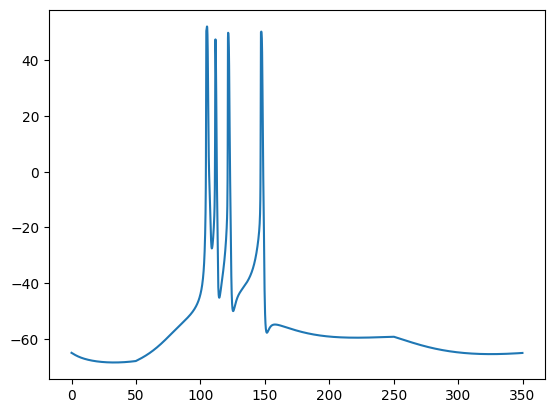

In [143]:
def try_neuron_simulation():
    brainstate.environ.set(dt=0.1 * u.ms)

    I = braintools.input.section(values=[0, 0.05, 0], durations=[50 * u.ms, 200 * u.ms, 100 * u.ms]) * u.uA
    times = u.math.arange(I.shape[0]) * brainstate.environ.get_dt()

    neu = HTC(1)
    neu.init_state()

    t0 = time.time()
    vs = brainstate.transform.for_loop(neu.step_run, times, I)
    t1 = time.time()
    print(f"Elapsed time: {t1 - t0:.4f} s")

    plt.plot(times.to_decimal(u.ms), u.math.squeeze(vs.to_decimal(u.mV)))
    plt.show()

if __name__ == '__main__':
    try_neuron_simulation()

## 丘脑网络建模

在完成对神经元的建模后，我们开始对完整的丘脑网络进行建模。

目前神经科学领域的大部分常见突触连接模型都可以在 `braincell` 中找到，但在此例中，出现了相对比较少见的 NMDA 突触的镁离子阻塞效应，我们需要手动对其建模。

我们要建立的 `MgBlock` 继承自 `SynOut` ，表示这是一个突触输出模型。

根据其公式：

$$I_{\text{NMDA}}(V) = \dfrac{g \, (E - V)}{1 + \exp \!\left( -\dfrac{V + 25}{12.5} \right)}$$

我们可以轻松对其建模。

In [144]:
class MgBlock(brainstate.nn.SynOut):
    def __init__(self, E=0. * u.mV):
        super(MgBlock, self).__init__()
        self.E = E

    def update(self, conductance, potential):
        return conductance * (self.E - potential) / (1 + u.math.exp(-(potential / u.mV + 25) / 12.5))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_33864\2860468575.py:1: DeprecationWarning: 'brainstate.nn.SynOut' is deprecated and will be removed in a future version. Please use 'brainpy.state.SynOut' instead.
  class MgBlock(brainstate.nn.SynOut):


同时，由于本例中 gap junction 的连接是基于空间距离和概率的，因此我们在此建立一个 `ProbDist` 。

此 `ProbDist` 类的作用是，给定前神经元群体和后神经元群体的规模，会根据以下规则生成一组突触连接：

- 只连接在二维平面中空间距离不超过 `dist` 的神经元
- 每对神经元有 `prob` 的概率被连接
- 每个前神经元有 `pre_ratio` 的概率参与连接
- `include_self` 控制是否允许自连接

基于以上规则，我们之后在进行网络建模时可以很具体精细的对 gap junction 进行建模。

In [145]:
class ProbDist:
    def __init__(self, dist=2., prob=0.3, pre_ratio=1.0, include_self=False):
        self.dist = dist

        @numba.njit
        def _pos2ind(pos, size):
            idx = 0
            for i, p in enumerate(pos):
                idx += p * np.prod(size[i + 1:])
            return idx

        @numba.njit
        def _connect_2d(pre_pos, pre_size, post_size):
            all_post_ids = []
            all_pre_ids = []
            if np.random.random() < pre_ratio:
                normalized_pos = np.zeros(2)
                for i in range(2):
                    pre_len = pre_size[i]
                    post_len = post_size[i]
                    normalized_pos[i] = pre_pos[i] * post_len / pre_len
                for i in range(post_size[0]):
                    for j in range(post_size[1]):
                        post_pos = np.asarray((i, j))
                        d = np.sqrt(np.sum(np.square(pre_pos - post_pos)))
                        if d <= dist:
                            if d == 0. and not include_self:
                                continue
                            if np.random.random() <= prob:
                                all_post_ids.append(_pos2ind(post_pos, post_size))
                                all_pre_ids.append(_pos2ind(pre_pos, pre_size))
            return all_pre_ids, all_post_ids  # Return filled part of the arrays

        self.connect = _connect_2d

    def __call__(self, pre_size, post_size):
        pre_size = np.asarray([pre_size[0] ** 0.5, pre_size[0] ** 0.5], dtype=int)
        post_size = np.asarray([post_size[0] ** 0.5, post_size[0] ** 0.5], dtype=int)
        connected_pres = []
        connected_posts = []
        pre_ids = np.meshgrid(*(np.arange(p) for p in pre_size), indexing='ij')
        pre_ids = tuple(
            [
                (np.moveaxis(p, 0, 1).flatten())
                if p.ndim > 1 else p.flatten()
                for p in pre_ids
            ]
        )
        size = np.prod(pre_size)

        for i in range(size):
            pre_pos = np.asarray([p[i] for p in pre_ids])
            pres, posts = self.connect(pre_pos, pre_size, post_size)
            connected_pres.extend(pres)
            connected_posts.extend(posts)
        return np.asarray(connected_pres), np.asarray(connected_posts)

在这个丘脑网络中，神经元按照比例排列分布：
- 49 个 HTC 神经元，排列成 $7 \times 7$ 的网格
- 144 个 RTC 神经元，排列成 $12 \times 12$ 的网格
- 64 个 IN 神经元，排列成 $8 \times 8$ 的网格
- 100 个 RE 神经元，排列成 $10 \times 10$ 的网格

所有神经元群体都被放置在一个二维网格中。

其网络连接如下：

![网络连接结构](../_static/image/braincell_HH_thalamus_oscillations_structure.png)

其中：

![注释](../_static/image/braincell_HH_thalamus_oscillations_structure_2.png)

噪声在本例中为频率为 100 Hz 的泊松输入，建模为 `noise2HTC` 、 `noise2RTC` 、 `noise2IN` 、 `noise2RE` 。

HTC 神经元和 RE 神经元拥有自身的 gap junction 连接，建模为 `gj_HTC` 和 `gj_RE` ，同时 RTC 神经元与 HTC 神经元间也拥有 gap junction 连接，建模为 `gj_RTC2HTC` 。

由 AMPA 受体介导的突触电流被建模为 `HTC2IN_ampa` 、 `HTC2RE_ampa` 、 `RTC2RE_ampa` 。

由 NMDA 受体介导的突触电流被建模为 `HTC2IN_nmda` 、 `HTC2RE_nmda` 、 `RTC2RE_nmda` 。

由 GABA 受体介导的突触电流被建模为 `IN2RTC` 、 `RE2RTC` 、 `RE2HTC` 、 `RE2IN` 、 `RE2RE` 。

结合参考文献中的相关参数进行建模，网络模型如下：

In [146]:
class Thalamus(brainstate.nn.Module):
    def __init__(
        self,
        g_input: Dict[str, float],
        g_KL: Dict[str, float],
        HTC_V_init: Callable = braintools.init.Constant(-65. * u.mV),
        RTC_V_init: Callable = braintools.init.Constant(-65. * u.mV),
        IN_V_init: Callable = braintools.init.Constant(-70. * u.mV),
        RE_V_init: Callable = braintools.init.Constant(-70. * u.mV),
    ):
        super(Thalamus, self).__init__()

        # populations
        self.HTC = HTC(7 * 7, gKL=g_KL['TC'], V_initializer=HTC_V_init)
        self.RTC = RTC(12 * 12, gKL=g_KL['TC'], V_initializer=RTC_V_init)
        self.RE = TRN(10 * 10, gKL=g_KL['RE'], V_initializer=IN_V_init)
        self.IN = IN(8 * 8, gKL=g_KL['IN'], V_initializer=RE_V_init)

        # noises
        self.noise2HTC = brainpy.state.AlignPostProj(
            brainpy.state.PoissonSpike(self.HTC.varshape, freqs=100 * u.Hz),
            comm=brainstate.nn.OneToOne(self.HTC.varshape, g_input['TC'], ),
            syn=brainpy.state.Expon.desc(self.HTC.varshape, tau=5. * u.ms),
            out=brainpy.state.COBA.desc(E=0. * u.mV),
            post=self.HTC,
        )
        self.noise2RTC = brainpy.state.AlignPostProj(
            brainpy.state.PoissonSpike(self.RTC.varshape, freqs=100 * u.Hz),
            comm=brainstate.nn.OneToOne(self.RTC.varshape, g_input['TC']),
            syn=brainpy.state.Expon.desc(self.RTC.varshape, tau=5. * u.ms),
            out=brainpy.state.COBA.desc(E=0. * u.mV),
            post=self.RTC,
        )
        self.noise2IN = brainpy.state.AlignPostProj(
            brainpy.state.PoissonSpike(self.IN.varshape, freqs=100 * u.Hz),
            comm=brainstate.nn.OneToOne(self.IN.varshape, g_input['IN']),
            syn=brainpy.state.Expon.desc(self.IN.varshape, tau=5. * u.ms),
            out=brainpy.state.COBA.desc(E=0. * u.mV),
            post=self.IN,
        )
        self.noise2RE = brainpy.state.AlignPostProj(
            brainpy.state.PoissonSpike(self.RE.varshape, freqs=100 * u.Hz),
            comm=brainstate.nn.OneToOne(self.RE.varshape, g_input['RE']),
            syn=brainpy.state.Expon.desc(self.RE.varshape, tau=5. * u.ms),
            out=brainpy.state.COBA.desc(E=0. * u.mV),
            post=self.RE,
        )

        # HTC cells were connected with gap junctions
        self.gj_HTC = brainpy.state.SymmetryGapJunction(
            self.HTC, 'V', conn=ProbDist(dist=2., prob=0.3), weight=1e-2 * u.siemens
        )

        # HTC provides feedforward excitation to INs
        self.HTC2IN_ampa = brainpy.state.CurrentProj(
            self.HTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.AMPA(self.HTC.varshape, alpha=0.94 / (u.ms * u.mM), beta=0.18 / u.ms)
            ).prefetch('g'),
            comm=brainstate.nn.FixedNumConn(self.HTC.varshape, self.IN.varshape, 0.3, 6e-3),
            out=brainpy.state.COBA(E=0. * u.mV),
            post=self.IN,
        )
        self.HTC2IN_nmda = brainpy.state.CurrentProj(
            self.HTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07),
            ).align_pre(
                brainpy.state.AMPA(self.HTC.varshape, alpha=1.0 / (u.ms * u.mM), beta=0.0067 / u.ms)
            ).prefetch('g'),
            comm=brainstate.nn.FixedNumConn(self.HTC.varshape, self.IN.varshape, 0.3, 3e-3),
            out=MgBlock(),
            post=self.IN,
        )

        # INs delivered feedforward inhibition to RTC cells
        self.IN2RTC = brainpy.state.CurrentProj(
            self.IN.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.GABAa(self.IN.varshape, alpha=10.5 / (u.ms * u.mM), beta=0.166 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.IN.varshape, self.RTC.varshape, 0.3, 3e-3),
            out=brainpy.state.COBA(E=-80. * u.mV),
            post=self.RTC,
        )

        # 20% RTC cells electrically connected with HTC cells
        self.gj_RTC2HTC = brainpy.state.SymmetryGapJunction(
            (self.RTC, self.HTC), 'V', conn=ProbDist(dist=2., prob=0.3, pre_ratio=0.2), weight=1 / 300 * u.mS
        )

        # Both HTC and RTC cells sent glutamatergic synapses to RE neurons, while
        # receiving GABAergic feedback inhibition from the RE population
        self.HTC2RE_ampa = brainpy.state.CurrentProj(
            self.HTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.AMPA(self.HTC.varshape, alpha=0.94 / (u.ms * u.mM), beta=0.18 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.HTC.varshape, self.RE.varshape, 0.2, 4e-3),
            out=brainpy.state.COBA(E=0. * u.mV),
            post=self.RE,
        )
        self.RTC2RE_ampa = brainpy.state.CurrentProj(
            self.RTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.AMPA(self.RTC.varshape, alpha=0.94 / (u.ms * u.mM), beta=0.18 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RTC.varshape, self.RE.varshape, 0.2, 4e-3),
            out=brainpy.state.COBA(E=0. * u.mV),
            post=self.RE,
        )
        self.HTC2RE_nmda = brainpy.state.CurrentProj(
            self.HTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.AMPA(self.HTC.varshape, alpha=1. / (u.ms * u.mM), beta=0.0067 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.HTC.varshape, self.RE.varshape, 0.2, 2e-3),
            out=MgBlock(),
            post=self.RE,
        )
        self.RTC2RE_nmda = brainpy.state.CurrentProj(
            self.RTC.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.AMPA(self.RTC.varshape, alpha=1. / (u.ms * u.mM), beta=0.0067 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RTC.varshape, self.RE.varshape, 0.2, 2e-3),
            out=MgBlock(),
            post=self.RE,
        )
        self.RE2HTC = brainpy.state.CurrentProj(
            self.RE.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.GABAa(self.RE.varshape, alpha=10.5 / (u.ms * u.mM), beta=0.166 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RE.varshape, self.HTC.varshape, 0.2, 3e-3),
            out=brainpy.state.COBA(E=-80. * u.mV),
            post=self.HTC,
        )
        self.RE2RTC = brainpy.state.CurrentProj(
            self.RE.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.GABAa(self.RE.varshape, alpha=10.5 / (u.ms * u.mM), beta=0.166 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RE.varshape, self.RTC.varshape, 0.2, 3e-3),
            out=brainpy.state.COBA(E=-80. * u.mV),
            post=self.RTC,
        )

        # RE neurons were connected with both gap junctions and GABAergic synapses
        self.gj_RE = brainpy.state.SymmetryGapJunction(
            self.RE, 'V', conn=ProbDist(dist=2., prob=0.3, pre_ratio=0.2), weight=1 / 300 * u.mS
        )
        self.RE2RE = brainpy.state.CurrentProj(
            self.RE.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.GABAa(self.RE.varshape, alpha=10.5 / (u.ms * u.mM), beta=0.166 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RE.varshape, self.RE.varshape, 0.2, 1e-3),
            out=brainpy.state.COBA(E=-70. * u.mV),
            post=self.RE,
        )

        # 10% RE neurons project GABAergic synapses to local interneurons
        # probability (0.05) was used for the RE->IN synapses according to experimental data
        self.RE2IN = brainpy.state.CurrentProj(
            self.RE.align_pre(
                brainpy.state.STD.desc(tau=700 * u.ms, U=0.07)
            ).align_pre(
                brainpy.state.GABAa(self.RE.varshape, alpha=10.5 / (u.ms * u.mM), beta=0.166 / u.ms)
            ).prefetch_delay('g', 2 * u.ms),
            comm=brainstate.nn.FixedNumConn(self.RE.varshape, self.IN.varshape, 0.05, 1e-3, afferent_ratio=0.1),
            out=brainpy.state.COBA(E=-80. * u.mV),
            post=self.IN,
        )

    def update(self, i, t, current):
        with brainstate.environ.context(t=t, i=i):
            self.noise2HTC()
            self.noise2RTC()
            self.noise2IN()
            self.noise2RE()

            self.HTC2IN_ampa()
            self.HTC2IN_nmda()

            self.IN2RTC()

            self.HTC2RE_ampa()
            self.RTC2RE_ampa()
            self.HTC2RE_nmda()
            self.RTC2RE_nmda()

            self.RE2HTC()
            self.RE2RTC()
            self.RE2RE()
            self.RE2IN()

            self.gj_HTC()
            self.gj_RTC2HTC()
            self.gj_RE()

            htc_spike = self.HTC(current)
            rtc_spike = self.RTC(current)
            re_spike = self.RE(current)
            in_spike = self.IN(current)

        return {
            'HTC.V': self.HTC.V.value,
            'RTC.V': self.RTC.V.value,
            'IN.V': self.IN.V.value,
            'RE.V': self.RE.V.value,
            'HTC.spike': htc_spike,
            'RTC.spike': rtc_spike,
            'RE.spike': re_spike,
            'IN.spike': in_spike,
        }

对于这个丘脑网络，不同的参数可以使其产生不同频率的振荡。

相关参数与振荡频率的对应关系如下：

![参数对应表](../_static/image/braincell_HH_thalamus_oscillations_parameters.png)

为便于模拟仿真，我们直接将参数包装好：

In [147]:
states = {
    'delta': dict(
        g_input={'IN': 1e-4 * u.mS, 'RE': 1e-4 * u.mS, 'TC': 1e-4 * u.mS},
        g_KL={'TC': 0.035 * u.mS / u.cm ** 2, 'RE': 0.03 * u.mS / u.cm ** 2, 'IN': 0.01 * u.mS / u.cm ** 2}
    ),
    'spindle': dict(
        g_input={'IN': 3e-4 * u.mS, 'RE': 3e-4 * u.mS, 'TC': 3e-4 * u.mS},
        g_KL={'TC': 0.01 * u.mS / u.cm ** 2, 'RE': 0.02 * u.mS / u.cm ** 2, 'IN': 0.015 * u.mS / u.cm ** 2}
    ),
    'alpha': dict(
        g_input={'IN': 1.5e-3 * u.mS, 'RE': 1.5e-3 * u.mS, 'TC': 1.5e-3 * u.mS},
        g_KL={'TC': 0. * u.mS / u.cm ** 2, 'RE': 0.01 * u.mS / u.cm ** 2, 'IN': 0.02 * u.mS / u.cm ** 2}
    ),
    'gamma': dict(
        g_input={'IN': 1.5e-3 * u.mS, 'RE': 1.5e-3 * u.mS, 'TC': 1.7e-2 * u.mS},
        g_KL={'TC': 0. * u.mS / u.cm ** 2, 'RE': 0.01 * u.mS / u.cm ** 2, 'IN': 0.02 * u.mS / u.cm ** 2}
    ),
}

为了在神经网络中模拟给神经元注入周期性刺激，我们需要定义一个函数 `rhythm_const_input` ，进而可以生成由节律的方波电流输入。

In [148]:
def rhythm_const_input(amp, freq, length, duration, t_start=0., t_end=None, dt=None):
    if t_end is None:
        t_end = duration
    if length > duration:
        raise ValueError(f'Expected length <= duration, while we got {length} > {duration}')
    sec_length = 1 / freq
    values, durations = [0. * u.mA], [t_start]
    for t in u.math.arange(t_start, t_end, sec_length):
        values.append(amp)
        if t + length <= t_end:
            durations.append(length)
            values.append(0. * u.mA)
            if t + sec_length <= t_end:
                durations.append(sec_length - length)
            else:
                durations.append(t_end - t - length)
        else:
            durations.append(t_end - t)
    values.append(0. * u.mA)
    durations.append(duration - t_end)
    return braintools.input.section(values=values, durations=durations)

为便于作图，封装好一个画时间序列曲线的小工具函数。

In [149]:
def line_plot(ax, xs, ys, ylabel=None, xlim=None):
    ax.plot(xs, ys)
    ax.set_xlabel('Time (ms)')
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlim is not None:
        ax.set_xlim(xlim)

同样，封装好一个画神经元脉冲光栅图的绘制函数。

In [150]:
def raster_plot(
    ax, times, spikes, ylabel='Neuron Index', xlabel='Time [ms]',
    xlim=None, marker='.', markersize=2, color='k'
):
    elements = np.where(spikes > 0.)
    index = elements[1]
    time = times[elements[0]]
    ax.plot(time, index, marker + color, markersize=markersize)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if xlim:
        ax.set_xlim(xlim)

对网络进行模拟。

In [151]:
def try_network(state='delta'):
    net = Thalamus(
        IN_V_init=braintools.init.Constant(-70. * u.mV),
        RE_V_init=braintools.init.Constant(-70. * u.mV),
        HTC_V_init=braintools.init.Constant(-80. * u.mV),
        RTC_V_init=braintools.init.Constant(-80. * u.mV),
        **states[state],
    )
    brainstate.nn.init_all_states(net)

    duration = 3e3 * u.ms  # 3 seconds
    currents = rhythm_const_input(
        2e-4 * u.mA,
        freq=4. * u.Hz,
        length=10. * u.ms,
        duration=duration,
        t_end=2e3 * u.ms,
        t_start=1e3 * u.ms
    )
    indices = np.arange(currents.shape[0])
    times = indices * brainstate.environ.get_dt()
    mon = brainstate.transform.for_loop(net.update, indices, times, currents, pbar=200)

    fig, gs = braintools.visualize.get_figure(5, 2, 2, 5)
    line_plot(fig.add_subplot(gs[0, :]), times, currents, ylabel='Current', xlim=(0, duration / u.ms))
    line_plot(fig.add_subplot(gs[1, 0]), times, mon.get('HTC.V'), ylabel='HTC', xlim=(0, duration / u.ms))
    line_plot(fig.add_subplot(gs[2, 0]), times, mon.get('RTC.V'), ylabel='RTC', xlim=(0, duration / u.ms))
    line_plot(fig.add_subplot(gs[3, 0]), times, mon.get('IN.V'), ylabel='IN', xlim=(0, duration / u.ms))
    line_plot(fig.add_subplot(gs[4, 0]), times, mon.get('RE.V'), ylabel='RE', xlim=(0, duration / u.ms))
    raster_plot(fig.add_subplot(gs[1, 1]), times, mon.get('HTC.spike'), xlim=(0, duration / u.ms))
    raster_plot(fig.add_subplot(gs[2, 1]), times, mon.get('RTC.spike'), xlim=(0, duration / u.ms))
    raster_plot(fig.add_subplot(gs[3, 1]), times, mon.get('IN.spike'), xlim=(0, duration / u.ms))
    raster_plot(fig.add_subplot(gs[4, 1]), times, mon.get('RE.spike'), xlim=(0, duration / u.ms))
    plt.suptitle(f'Thalamus Network State: {state}')
    plt.show()

此处我们以产生 `alpha` 和 `gamma` 振荡的参数为例，运行仿真程序。

  0%|          | 0/30000 [00:00<?, ?it/s]

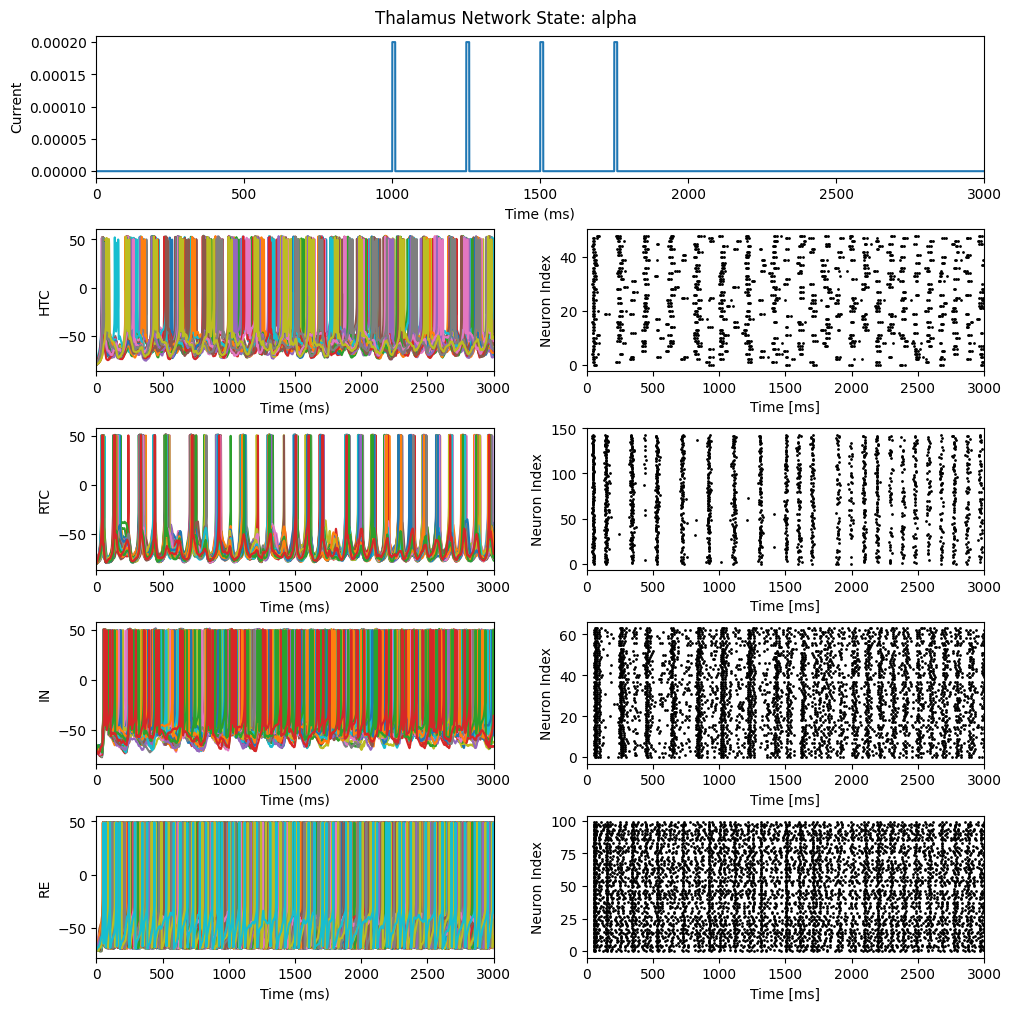

  0%|          | 0/30000 [00:00<?, ?it/s]

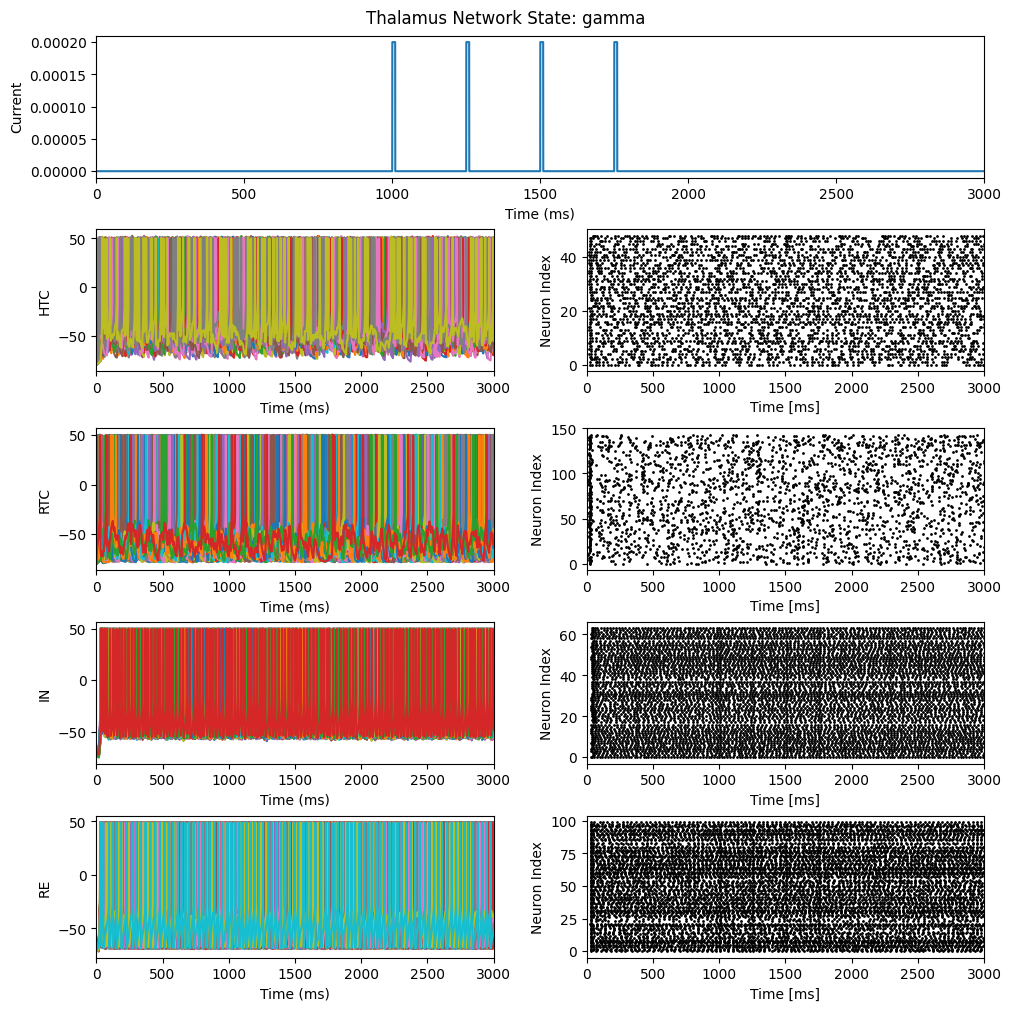

In [152]:
if __name__ == '__main__':
    try_network('alpha')
    try_network('gamma')

观察运行结果，我们构建的丘脑神经网络模型成功的展现了相关的振荡节律。

本文中举例的模型来自：

- G, Li., Henriquez, C. S., & Fröhlich, F. (2017), Unified thalamic model generates multiple distinct oscillations with state-dependent entrainment by stimulation., PLoS Comput. Biol., 13, 10, e1005797
